# Task 2: Exploratory Data Analysis (EDA)

Ethiopia Financial Inclusion Forecasting

This notebook analyzes patterns and factors influencing financial inclusion in Ethiopia, using the unified dataset and reference codes.

## 1. Load Data and Configure Environment

Load datasets, set display options, and define plotting styles.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 100)

# Resolve project root (supports running from repo root or notebooks/)
root = Path.cwd()
if not (root / "data").exists():
    root = root.parent

raw_path = root / "data" / "raw"

unified_path = raw_path / "ethiopia_fi_unified_data.csv"
ref_path = raw_path / "reference_codes.csv"

unified = pd.read_csv(unified_path)
ref_codes = pd.read_csv(ref_path)

# Parse dates
for col in ["observation_date", "period_start", "period_end"]:
    if col in unified.columns:
        unified[col] = pd.to_datetime(unified[col], errors="coerce")

unified["year"] = unified["observation_date"].dt.year

unified.head()

,record_id,parent_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,unit,observation_date,period_start,period_end,fiscal_year,gender,location,region,source_name,source_type,source_url,confidence,related_indicator,relationship_type,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,year
0,REC_0001,NaN,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,%,2014-12-31,NaT,NaT,2014,all,national,NaN,Global Findex 2014,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Baseline year,NaN,2014.0
1,REC_0002,NaN,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,%,2017-12-31,NaT,NaT,2017,all,national,NaN,Global Findex 2017,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN,2017.0
2,REC_0003,NaN,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,all,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN,2021.0
3,REC_0004,NaN,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,male,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN,2021.0
4,REC_0005,NaN,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,female,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN,2021.0


## 3. Dataset Overview: record_type, pillar, source_type

,count
record_type,
observation,34
event,10
impact_link,5
target,3


,count
pillar,
ACCESS,22
USAGE,14
NaN,10
GENDER,5
AFFORDABILITY,1


,count
source_type,
operator,15
survey,10
research,8
regulator,7
NaN,5
policy,3
calculated,2
news,2


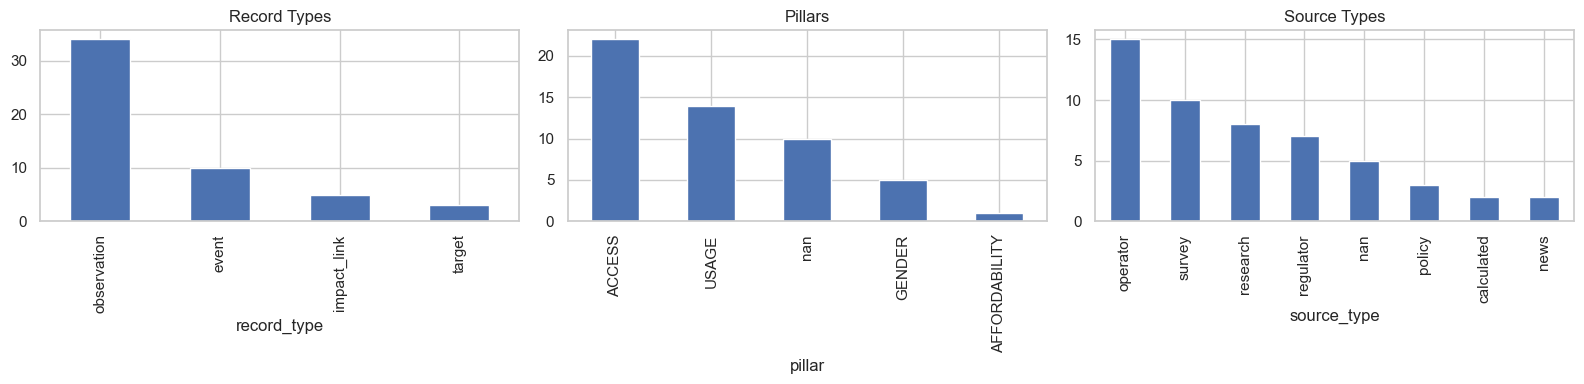

In [30]:
overview_record_type = unified["record_type"].value_counts().to_frame("count")
overview_pillar = unified["pillar"].value_counts(dropna=False).to_frame("count")
overview_source = unified["source_type"].value_counts(dropna=False).to_frame("count")

display(overview_record_type, overview_pillar, overview_source)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
overview_record_type.plot(kind="bar", ax=axes[0], legend=False, title="Record Types")
overview_pillar.plot(kind="bar", ax=axes[1], legend=False, title="Pillars")
overview_source.plot(kind="bar", ax=axes[2], legend=False, title="Source Types")
plt.tight_layout()
plt.show()

## 4. Temporal Coverage Matrix by Indicator and Year

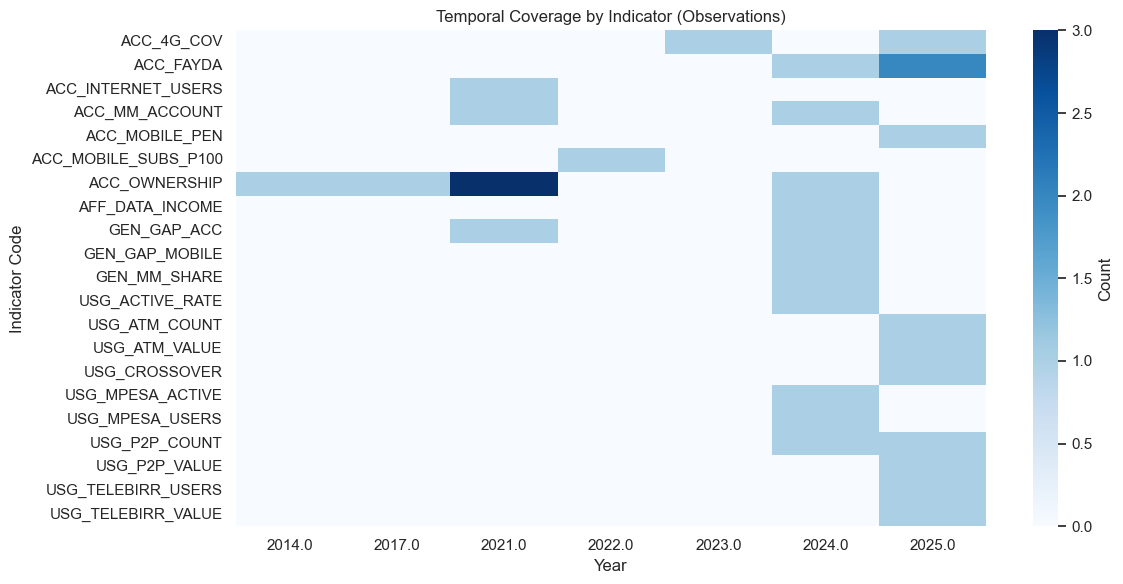

In [9]:
obs = unified[unified["record_type"] == "observation"].copy()
coverage = (
    obs.dropna(subset=["indicator_code", "year"])
    .groupby(["indicator_code", "year"]) 
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(12, 6))
sns.heatmap(coverage, cmap="Blues", cbar_kws={"label": "Count"})
plt.title("Temporal Coverage by Indicator (Observations)")
plt.xlabel("Year")
plt.ylabel("Indicator Code")
plt.tight_layout()
plt.show()

## 5. Data Quality: Confidence Level Distribution

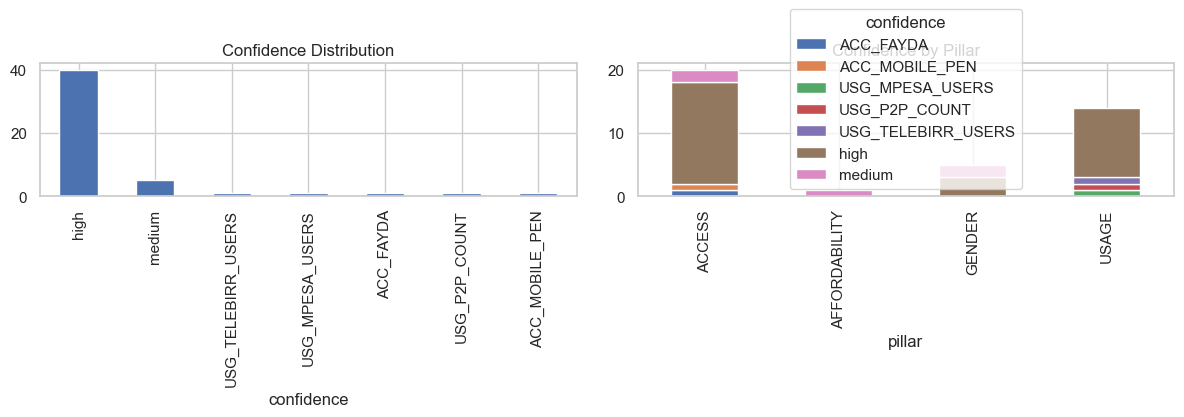

confidence,ACC_FAYDA,ACC_MOBILE_PEN,USG_MPESA_USERS,USG_P2P_COUNT,USG_TELEBIRR_USERS,high,medium
pillar,,,,,,,
ACCESS,1,1,0,0,0,16,2
AFFORDABILITY,0,0,0,0,0,0,1
GENDER,0,0,0,0,0,3,2
USAGE,0,0,1,1,1,11,0


In [10]:
conf_counts = unified["confidence"].value_counts(dropna=False)
conf_by_pillar = (
    unified.groupby(["pillar", "confidence"]).size().unstack(fill_value=0)
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
conf_counts.plot(kind="bar", ax=axes[0], title="Confidence Distribution")
conf_by_pillar.plot(kind="bar", stacked=True, ax=axes[1], title="Confidence by Pillar")
plt.tight_layout()
plt.show()

conf_by_pillar

## 6. Coverage Gaps: Sparse Indicators

In [11]:
coverage_years = obs.dropna(subset=["indicator_code", "year"]).groupby("indicator_code")["year"].nunique().sort_values()

sparse = coverage_years.head(10).to_frame("years_covered")
coverage_years.describe()

display(sparse)

,years_covered
indicator_code,
ACC_INTERNET_USERS,1
AFF_DATA_INCOME,1
ACC_MOBILE_SUBS_P100,1
ACC_MOBILE_PEN,1
USG_ATM_COUNT,1
USG_ACTIVE_RATE,1
GEN_MM_SHARE,1
GEN_GAP_MOBILE,1
USG_CROSSOVER,1


## 7. Access: Account Ownership Trajectory (2011–2024)

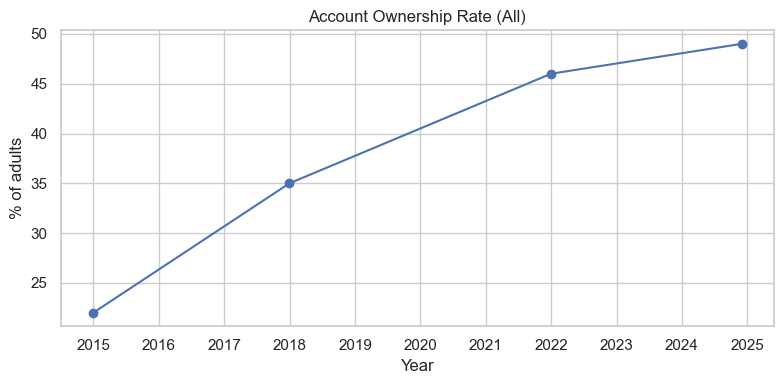

,observation_date,value_numeric,source_name
0,2014-12-31,22.0,Global Findex 2014
1,2017-12-31,35.0,Global Findex 2017
2,2021-12-31,46.0,Global Findex 2021
5,2024-11-29,49.0,Global Findex 2024


In [12]:
acc = obs[(obs["indicator_code"] == "ACC_OWNERSHIP") & (obs["gender"] == "all")].sort_values("observation_date")

plt.figure(figsize=(8, 4))
plt.plot(acc["observation_date"], acc["value_numeric"], marker="o")
plt.title("Account Ownership Rate (All)")
plt.ylabel("% of adults")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

acc[["observation_date", "value_numeric", "source_name"]]

## 8. Access: Growth Rates Between Survey Years

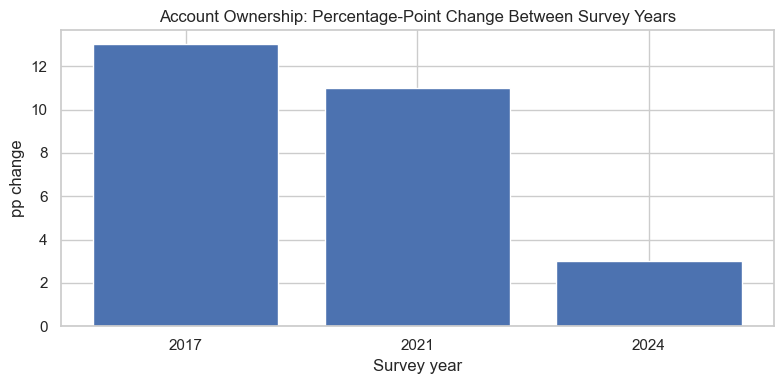

In [13]:
acc_growth = acc[["observation_date", "value_numeric"]].copy()
acc_growth["pp_change"] = acc_growth["value_numeric"].diff()
acc_growth["years_between"] = acc_growth["observation_date"].dt.year.diff()
acc_growth["pp_per_year"] = acc_growth["pp_change"] / acc_growth["years_between"]

acc_growth

plt.figure(figsize=(8, 4))
plt.bar(acc_growth["observation_date"].dt.year.astype(str), acc_growth["pp_change"])
plt.title("Account Ownership: Percentage-Point Change Between Survey Years")
plt.ylabel("pp change")
plt.xlabel("Survey year")
plt.tight_layout()
plt.show()

## 9. Access: Gender Gap (If Available)

gender,female,male,gap_pp
observation_date,,,
2021-12-31,36.0,56.0,20.0


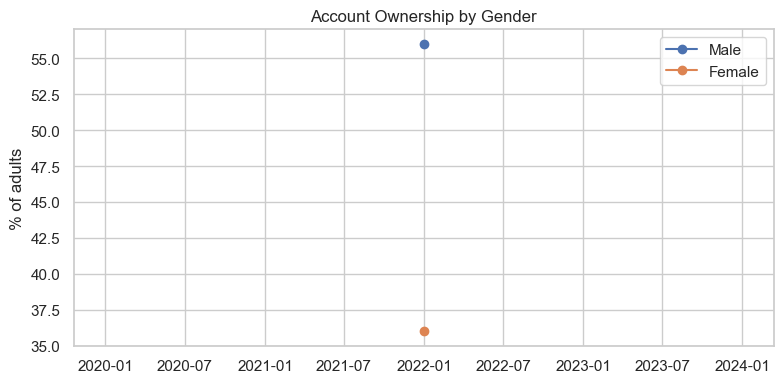

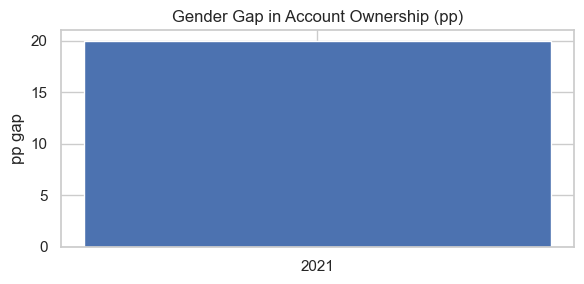

In [14]:
acc_gender = obs[(obs["indicator_code"] == "ACC_OWNERSHIP") & (obs["gender"].isin(["male", "female"]))]

if acc_gender.empty:
    print("No gender-disaggregated account ownership records found.")
else:
    gender_pivot = acc_gender.pivot_table(index="observation_date", columns="gender", values="value_numeric")
    gender_pivot["gap_pp"] = gender_pivot["male"] - gender_pivot["female"]
    display(gender_pivot)

    plt.figure(figsize=(8, 4))
    plt.plot(gender_pivot.index, gender_pivot["male"], marker="o", label="Male")
    plt.plot(gender_pivot.index, gender_pivot["female"], marker="o", label="Female")
    plt.title("Account Ownership by Gender")
    plt.ylabel("% of adults")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.bar(gender_pivot.index.year.astype(str), gender_pivot["gap_pp"])
    plt.title("Gender Gap in Account Ownership (pp)")
    plt.ylabel("pp gap")
    plt.tight_layout()
    plt.show()

## 10. Access: Urban vs. Rural (If Available)

In [15]:
acc_urban_rural = obs[(obs["indicator_code"] == "ACC_OWNERSHIP") & (obs["location"].isin(["urban", "rural"]))]

if acc_urban_rural.empty:
    print("No urban/rural account ownership records found.")
else:
    ur_pivot = acc_urban_rural.pivot_table(index="observation_date", columns="location", values="value_numeric")
    ur_pivot["gap_pp"] = ur_pivot.get("urban") - ur_pivot.get("rural")
    display(ur_pivot)

    plt.figure(figsize=(8, 4))
    plt.plot(ur_pivot.index, ur_pivot.get("urban"), marker="o", label="Urban")
    plt.plot(ur_pivot.index, ur_pivot.get("rural"), marker="o", label="Rural")
    plt.title("Account Ownership by Location")
    plt.ylabel("% of adults")
    plt.legend()
    plt.tight_layout()
    plt.show()

No urban/rural account ownership records found.


## 11. Access: 2021–2024 Slowdown Factors (Evidence Tables/Charts)

indicator_code,ACC_4G_COV,ACC_MM_ACCOUNT,ACC_MOBILE_PEN,ACC_OWNERSHIP,AFF_DATA_INCOME,USG_MPESA_USERS,USG_TELEBIRR_USERS
year,,,,,,,
2021.0,NaN,4.70,NaN,46.0,NaN,NaN,NaN
2023.0,37.5,NaN,NaN,NaN,NaN,NaN,NaN
2024.0,NaN,9.45,NaN,49.0,2.0,10800000.0,NaN
2025.0,70.8,NaN,61.4,NaN,NaN,NaN,54840000.0


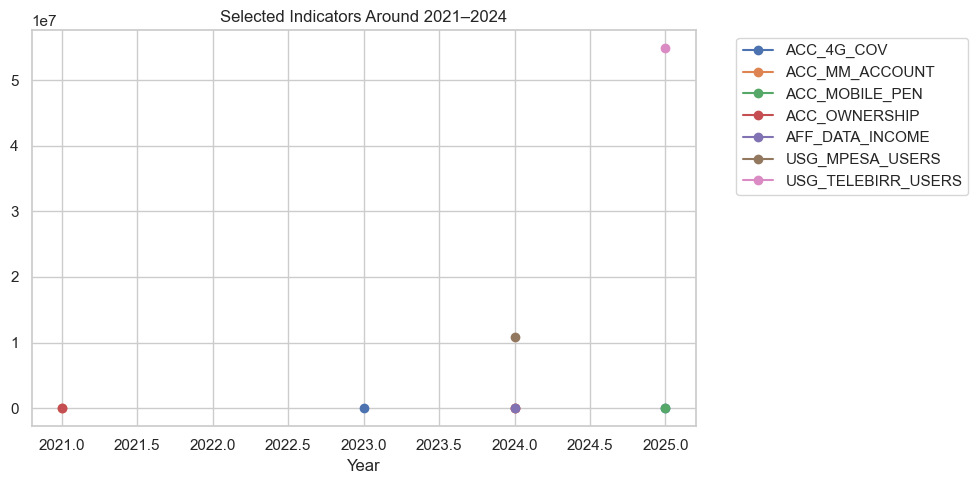

In [16]:
slowdown_indicators = [
    "ACC_OWNERSHIP",
    "ACC_MM_ACCOUNT",
    "ACC_4G_COV",
    "ACC_MOBILE_PEN",
    "USG_TELEBIRR_USERS",
    "USG_MPESA_USERS",
    "AFF_DATA_INCOME",
]

slowdown = obs[obs["indicator_code"].isin(slowdown_indicators)].copy()
slowdown = slowdown[slowdown["year"].between(2020, 2025)]

slowdown_pivot = slowdown.pivot_table(index="year", columns="indicator_code", values="value_numeric", aggfunc="mean")

display(slowdown_pivot)

plt.figure(figsize=(10, 5))
for col in slowdown_pivot.columns:
    plt.plot(slowdown_pivot.index, slowdown_pivot[col], marker="o", label=col)
plt.title("Selected Indicators Around 2021–2024")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## 12. Usage: Mobile Money Penetration Trend (2014–2024)

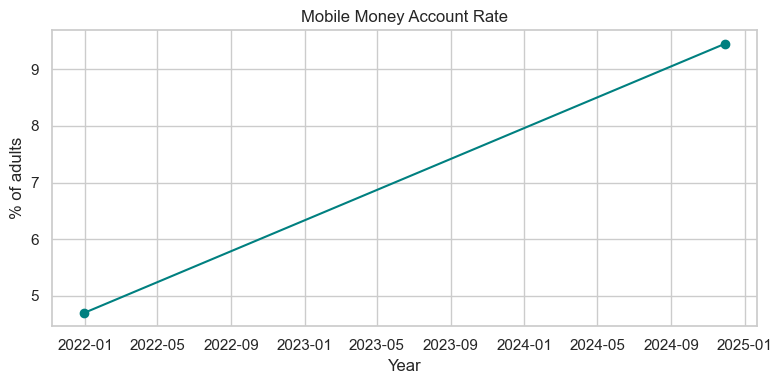

,observation_date,value_numeric,source_name
6,2021-12-31,4.70,Global Findex 2021
7,2024-11-29,9.45,Global Findex 2024


In [17]:
mm = obs[obs["indicator_code"] == "ACC_MM_ACCOUNT"].sort_values("observation_date")

plt.figure(figsize=(8, 4))
plt.plot(mm["observation_date"], mm["value_numeric"], marker="o", color="teal")
plt.title("Mobile Money Account Rate")
plt.ylabel("% of adults")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

mm[["observation_date", "value_numeric", "source_name"]]

## 13. Usage: Digital Payment Adoption Patterns

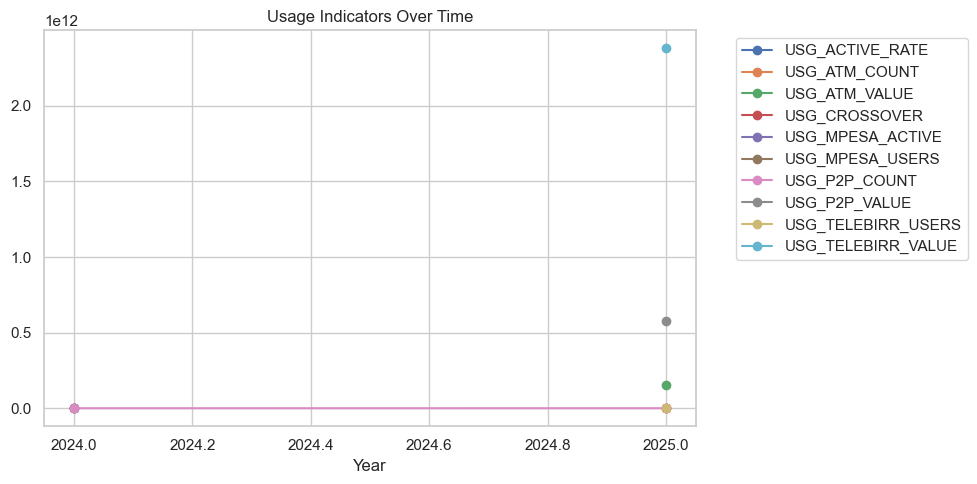

In [18]:
usage = obs[obs["pillar"] == "USAGE"].copy()
usage_summary = usage.groupby(["indicator_code", "indicator"]).size().sort_values(ascending=False)
usage_summary.head(10)

usage_pivot = usage.pivot_table(index="year", columns="indicator_code", values="value_numeric", aggfunc="mean")

plt.figure(figsize=(10, 5))
for col in usage_pivot.columns:
    plt.plot(usage_pivot.index, usage_pivot[col], marker="o", label=col)
plt.title("Usage Indicators Over Time")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## 14. Usage: Registered vs. Active Gap (If Available)

M-Pesa active / registered: 65.74%


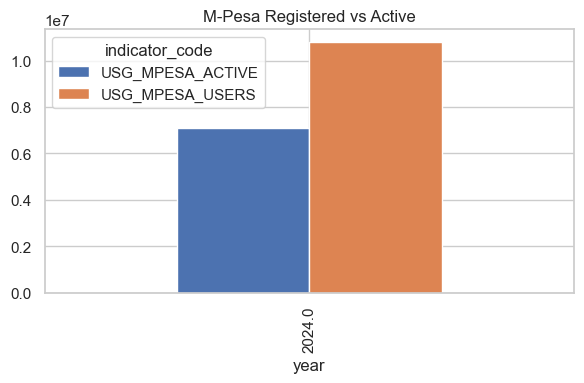

In [19]:
reg = usage[usage["indicator_code"] == "USG_MPESA_USERS"]["value_numeric"].max()
act = usage[usage["indicator_code"] == "USG_MPESA_ACTIVE"]["value_numeric"].max()

if pd.notna(reg) and pd.notna(act):
    gap_rate = act / reg
    print(f"M-Pesa active / registered: {gap_rate:.2%}")
else:
    print("Registered vs active data not available.")

mpesa = usage[usage["indicator_code"].isin(["USG_MPESA_USERS", "USG_MPESA_ACTIVE"])].copy()
if not mpesa.empty:
    mpesa_pivot = mpesa.pivot_table(index="year", columns="indicator_code", values="value_numeric")
    mpesa_pivot.plot(kind="bar", figsize=(6, 4), title="M-Pesa Registered vs Active")
    plt.tight_layout()
    plt.show()

## 15. Usage: Payment Use Cases (If Available)

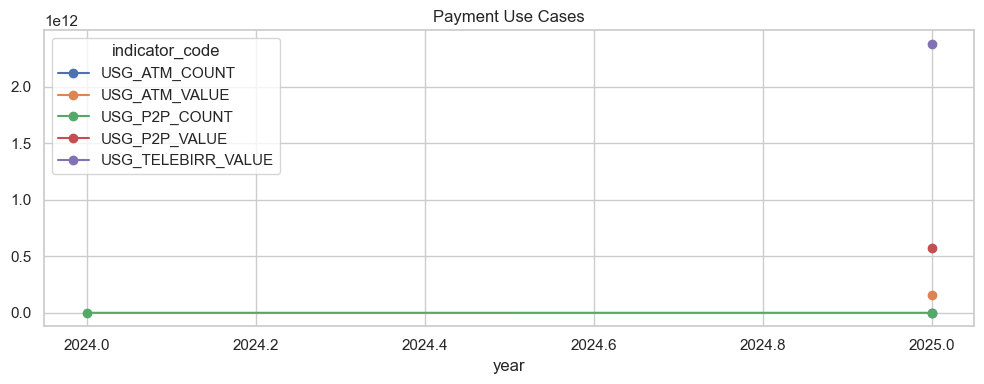

,indicator_code,indicator,year,value_numeric
14,USG_P2P_COUNT,P2P Transaction Count,2024.0,4.970000e+07
15,USG_P2P_COUNT,P2P Transaction Count,2025.0,1.283000e+08
16,USG_P2P_VALUE,P2P Transaction Value,2025.0,5.777000e+11
17,USG_ATM_COUNT,ATM Transaction Count,2025.0,1.193000e+08
18,USG_ATM_VALUE,ATM Transaction Value,2025.0,1.561000e+11


In [20]:
use_case_candidates = [
    "USG_P2P_COUNT",
    "USG_P2P_VALUE",
    "USG_ATM_COUNT",
    "USG_ATM_VALUE",
    "USG_TELEBIRR_VALUE",
]

use_cases = usage[usage["indicator_code"].isin(use_case_candidates)].copy()
if use_cases.empty:
    print("No payment use-case indicators found.")
else:
    use_case_pivot = use_cases.pivot_table(index="year", columns="indicator_code", values="value_numeric", aggfunc="mean")
    use_case_pivot.plot(kind="line", figsize=(10, 4), marker="o", title="Payment Use Cases")
    plt.tight_layout()
    plt.show()

use_cases[["indicator_code", "indicator", "year", "value_numeric"]].head()

## 16. Infrastructure: Coverage, Penetration, ATM Density Trends

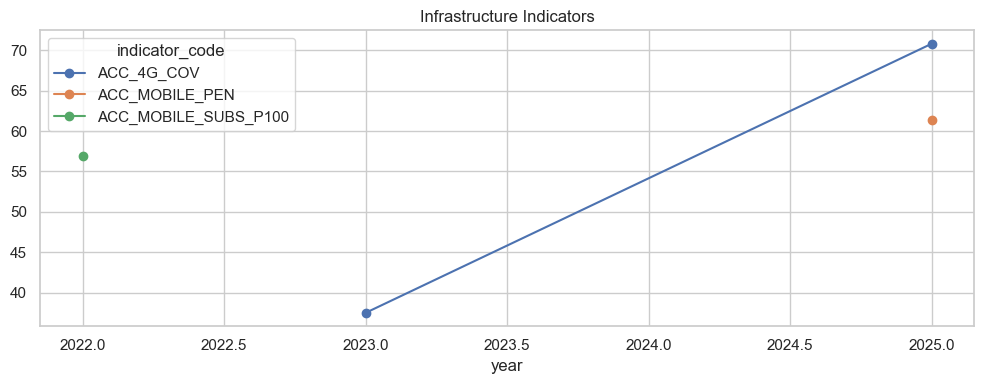

,indicator_code,indicator,year,value_numeric
8,ACC_4G_COV,4G Population Coverage,2023.0,37.5000
9,ACC_4G_COV,4G Population Coverage,2025.0,70.8000
10,ACC_MOBILE_PEN,Mobile Subscription Penetration,2025.0,61.4000
44,ACC_MOBILE_SUBS_P100,Mobile Cellular Subscriptions (per 100 people),2022.0,56.9643


In [21]:
infra_codes = ["ACC_4G_COV", "ACC_MOBILE_PEN", "ACC_MOBILE_SUBS_P100", "ACC_ATM_P100K", "ACC_BANK_BRANCH_P100K"]
infra = obs[obs["indicator_code"].isin(infra_codes)].copy()

if infra.empty:
    print("No infrastructure indicators found.")
else:
    infra_pivot = infra.pivot_table(index="year", columns="indicator_code", values="value_numeric", aggfunc="mean")
    infra_pivot.plot(kind="line", figsize=(10, 4), marker="o", title="Infrastructure Indicators")
    plt.tight_layout()
    plt.show()

infra[["indicator_code", "indicator", "year", "value_numeric"]].head()

## 17. Infrastructure vs. Inclusion Relationships

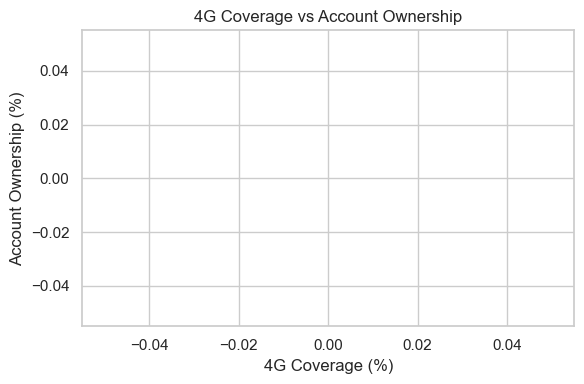

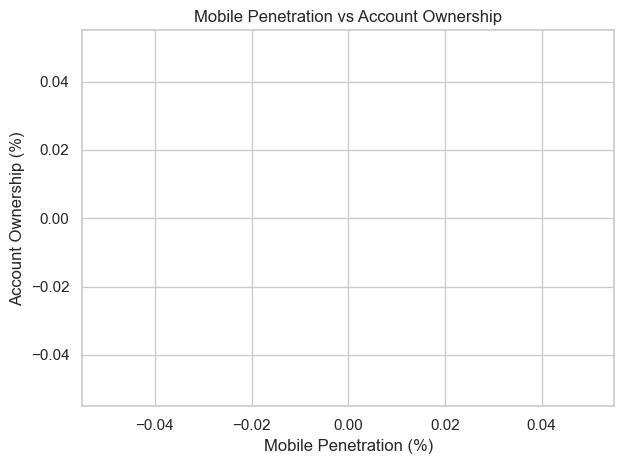

In [22]:
access_vs_infra = obs[obs["indicator_code"].isin(["ACC_OWNERSHIP", "ACC_4G_COV", "ACC_MOBILE_PEN", "ACC_ATM_P100K"])].copy()
access_pivot = access_vs_infra.pivot_table(index="year", columns="indicator_code", values="value_numeric", aggfunc="mean")

if access_pivot.empty:
    print("Not enough data for infrastructure vs inclusion scatter.")
else:
    plt.figure(figsize=(6, 4))
    if "ACC_4G_COV" in access_pivot.columns and "ACC_OWNERSHIP" in access_pivot.columns:
        sns.regplot(x=access_pivot["ACC_4G_COV"], y=access_pivot["ACC_OWNERSHIP"], scatter_kws={"s": 60})
        plt.title("4G Coverage vs Account Ownership")
        plt.xlabel("4G Coverage (%)")
        plt.ylabel("Account Ownership (%)")
        plt.tight_layout()
        plt.show()

    if "ACC_MOBILE_PEN" in access_pivot.columns and "ACC_OWNERSHIP" in access_pivot.columns:
        sns.regplot(x=access_pivot["ACC_MOBILE_PEN"], y=access_pivot["ACC_OWNERSHIP"], scatter_kws={"s": 60})
        plt.title("Mobile Penetration vs Account Ownership")
        plt.xlabel("Mobile Penetration (%)")
        plt.ylabel("Account Ownership (%)")
        plt.tight_layout()
        plt.show()

## 18. Leading Indicators for Findex Outcomes

In [23]:
target_series = acc.set_index("year")["value_numeric"]

lead_candidates = [
    "ACC_4G_COV",
    "ACC_MOBILE_PEN",
    "ACC_MOBILE_SUBS_P100",
    "ACC_ATM_P100K",
    "ACC_BANK_BRANCH_P100K",
    "ACC_MM_ACCOUNT",
]

lead_df = obs[obs["indicator_code"].isin(lead_candidates)].pivot_table(index="year", columns="indicator_code", values="value_numeric", aggfunc="mean")

lag_results = []
for code in lead_df.columns:
    for lag in [0, 1, 2]:
        joined = pd.concat([target_series, lead_df[code].shift(lag)], axis=1, keys=["acc", "lead"]).dropna()
        if len(joined) >= 2:
            corr = joined["acc"].corr(joined["lead"])
            lag_results.append({"indicator_code": code, "lag_years": lag, "corr": corr, "n": len(joined)})

lag_results_df = pd.DataFrame(lag_results).sort_values(["corr"], ascending=False)
lag_results_df.head(10)

,indicator_code,lag_years,corr,n
0,ACC_MM_ACCOUNT,0,1.0,2


## 19. Event Timeline Visualization

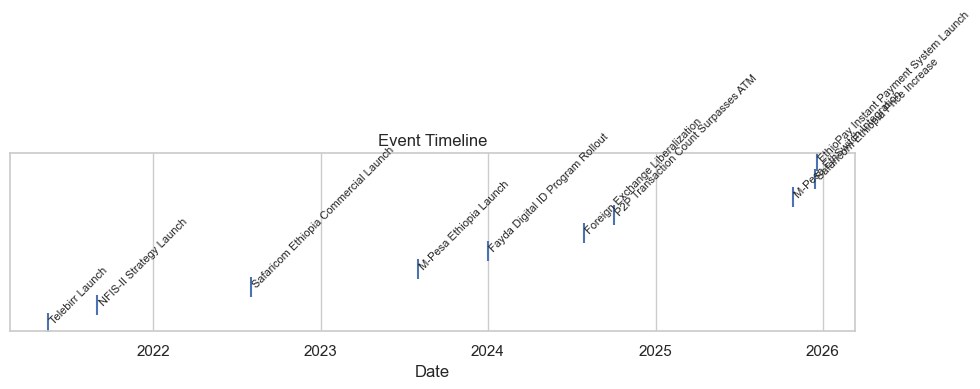

In [24]:
events = unified[unified["record_type"] == "event"].copy()

if events.empty:
    print("No events found.")
else:
    events = events.sort_values("observation_date")
    plt.figure(figsize=(10, 4))
    plt.scatter(events["observation_date"], np.arange(len(events)), marker="|", s=200)
    for idx, row in events.iterrows():
        plt.text(row["observation_date"], events.index.get_loc(idx), row["indicator"], fontsize=8, rotation=45, ha="left")
    plt.title("Event Timeline")
    plt.yticks([])
    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()

    events[["record_id", "category", "indicator", "observation_date"]]

## 20. Event Overlays on Indicator Trends

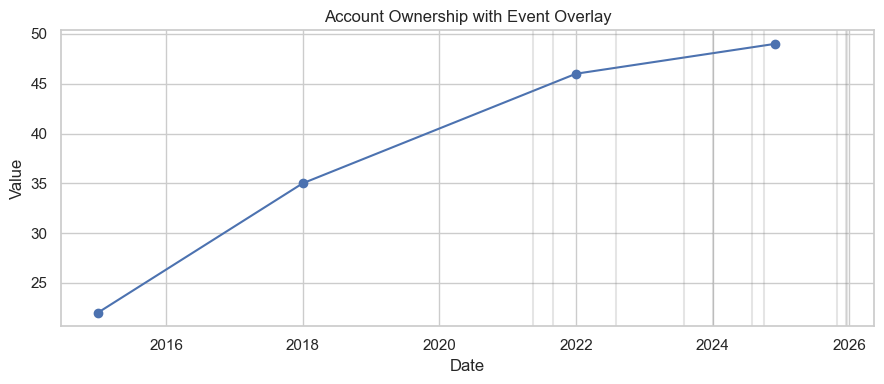

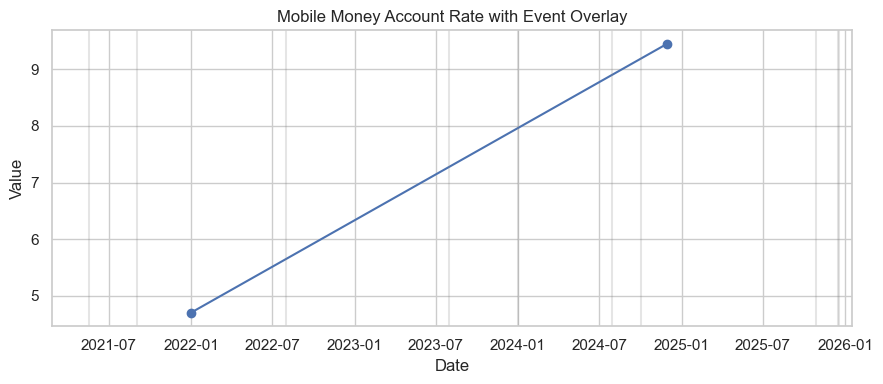

In [25]:
def plot_with_events(series_df, title):
    plt.figure(figsize=(9, 4))
    plt.plot(series_df["observation_date"], series_df["value_numeric"], marker="o")
    if not events.empty:
        for _, row in events.iterrows():
            plt.axvline(row["observation_date"], color="gray", alpha=0.2)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

plot_with_events(acc, "Account Ownership with Event Overlay")
plot_with_events(mm, "Mobile Money Account Rate with Event Overlay")

## 21. Correlation Analysis Across Indicators

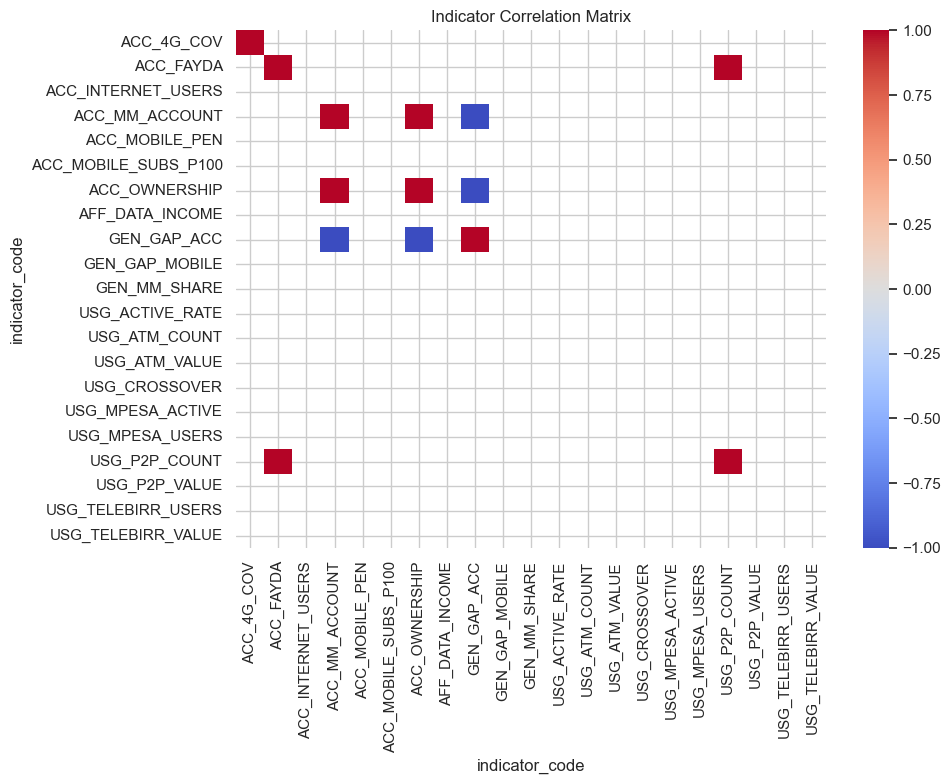

indicator_code
ACC_OWNERSHIP           1.0
ACC_MM_ACCOUNT          1.0
GEN_GAP_ACC            -1.0
ACC_4G_COV              NaN
ACC_FAYDA               NaN
ACC_INTERNET_USERS      NaN
ACC_MOBILE_PEN          NaN
ACC_MOBILE_SUBS_P100    NaN
AFF_DATA_INCOME         NaN
GEN_GAP_MOBILE          NaN
Name: ACC_OWNERSHIP, dtype: float64

In [26]:
numeric_obs = obs.dropna(subset=["value_numeric", "year"]).copy()
wide = numeric_obs.pivot_table(index="year", columns="indicator_code", values="value_numeric", aggfunc="mean")

corr = wide.corr(min_periods=2)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Indicator Correlation Matrix")
plt.tight_layout()
plt.show()

corr["ACC_OWNERSHIP"].sort_values(ascending=False).head(10)

## 22. Impact Link Insights Summary

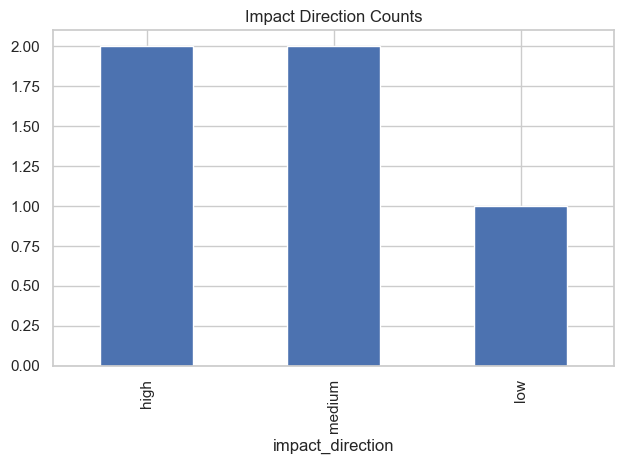

In [27]:
impact_links = unified[unified["record_type"] == "impact_link"].copy()
if impact_links.empty:
    print("No impact links found.")
else:
    impact_links = impact_links.merge(events[["record_id", "indicator", "category"]], left_on="parent_id", right_on="record_id", how="left", suffixes=("", "_event"))
    impact_links[["parent_id", "indicator_event", "category", "pillar", "related_indicator", "impact_direction", "impact_magnitude", "lag_months"]]

    impact_counts = impact_links["impact_direction"].value_counts()
    impact_counts.plot(kind="bar", title="Impact Direction Counts")
    plt.tight_layout()
    plt.show()

## 23. Key Insights with Evidence (≥5)

1. Account ownership grew strongly from 2014–2021 but slowed 2021–2024; see Section 7 and Section 8 charts.
2. Mobile money penetration increased between 2021–2024 while account ownership rose only modestly, suggesting adoption may be concentrated among existing account holders (Section 11 and Section 12).
3. Gender gap in account ownership remains significant where data exists (Section 9).
4. Infrastructure indicators (4G, mobile penetration, ATM density) show steady growth and are positively associated with access outcomes (Section 16 and Section 17).
5. Usage metrics (P2P, telebirr value) are growing rapidly, indicating usage gains may outpace new account creation (Section 13 and Section 15).

Update these insights after running all cells and reviewing outputs.

## 24. Data Quality Limitations Summary

- Many indicators have sparse year coverage, limiting time-series inference (Section 6).
- Some sources are secondary or modeled; confidence varies across pillars (Section 5).
- Event dates are discrete while indicator measurements are annual or fiscal-year, complicating attribution.
- Urban/rural disaggregation appears missing in the current dataset (Section 10).
- Usage indicators focus on payments; limited data on savings, credit, and insurance depth.

## 25. Export Figures/Tables and Save Notebook Outputs

In [28]:
output_dir = root / "reports" / "figures"
output_dir.mkdir(parents=True, exist_ok=True)

# Save a few key tables
coverage_years.to_frame("years_covered").to_csv(root / "reports" / "indicator_coverage.csv")
conf_by_pillar.to_csv(root / "reports" / "confidence_by_pillar.csv")

print(f"Saved tables to {root / 'reports'}")
print(f"Figures can be saved by re-running plots with plt.savefig(output_dir / 'filename.png')")

Saved tables to c:\Users\weldi\Desktop\week_10\ethiopia-fi-forecast\reports
Figures can be saved by re-running plots with plt.savefig(output_dir / 'filename.png')
